## cyclegan horse2zebra directml

- forked from LynnHo/CycleGAN-Tensorflow-2
- need windows x64, 8gb shared gpu memory, miniconda 
- to do: yolov9 arch
- miniconda:
    - conda create --name tfdml_plugin python=3.10
    - conda activate tfdml_plugin
    - git clone https://github.com/adam-blip/CycleGan-directml
    - cd CycleGan-directml
    - pip install jupyter tensorflow-cpu==2.10.0 tensorflow_addons oyaml tensorflow-directml-plugin scikit-image numpy<2 tqdm matplotlib
    - jupyter notebook cycleGan.ipynb

In [1]:
import functools

import imlib as im
import numpy as np
import pylib as py
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tf2lib as tl
import tf2gan as gan
import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

import data
#import module


C:\Users\User\miniconda3\envs\tfdml_plugin\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\User\miniconda3\envs\tfdml_plugin\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

In [2]:
# ==============================================================================
# =                                   param                                    =
# ==============================================================================

args = type('obj', (object,), {
    'dataset' : 'horse2zebra',
    'datasets_dir' : 'datasets',
    'load_size' : 286, # load image to this size
    'crop_size' : 256, # then crop to this size
    'batch_size' : 1,
    'epochs' : 200,
    'epoch_decay' : 100, # epoch to start decaying learning rate
    'lr' : 0.0002,
    'beta_1' : 0.5,
    'adversarial_loss_mode' : 'lsgan', #'gan', 'hinge_v1', 'hinge_v2', 'lsgan', 'wgan'
    'gradient_penalty_mode' : 'none', #'none', 'dragan', 'wgan-gp'
    'gradient_penalty_weight' : 10.0,
    'cycle_loss_weight' : 10.0,
    'identity_loss_weight' : 0.0,
    'pool_size' : 50 # pool size to store fake samples
    
})

# output_dir
output_dir = py.join('output', args.dataset)
py.mkdir(output_dir)


In [3]:
# ==============================================================================
# =                                    data                                    =
# ==============================================================================

A_img_paths = py.glob(py.join(args.datasets_dir, args.dataset, 'trainA'), '*.jpg')
B_img_paths = py.glob(py.join(args.datasets_dir, args.dataset, 'trainB'), '*.jpg')
A_B_dataset, len_dataset = data.make_zip_dataset(A_img_paths, B_img_paths, args.batch_size, args.load_size, args.crop_size, training=True, repeat=False)

A2B_pool = data.ItemPool(args.pool_size)
B2A_pool = data.ItemPool(args.pool_size)

A_img_paths_test = py.glob(py.join(args.datasets_dir, args.dataset, 'testA'), '*.jpg')
B_img_paths_test = py.glob(py.join(args.datasets_dir, args.dataset, 'testB'), '*.jpg')
A_B_dataset_test, _ = data.make_zip_dataset(A_img_paths_test, B_img_paths_test, args.batch_size, args.load_size, args.crop_size, training=False, repeat=True)


In [4]:
def fast_normalization(x): # use clipping instead of batchnormalization for network stabilization
    return Lambda(lambda x: K.clip(x, -1, 1), output_shape=lambda s: (s[0], s[1], s[2], s[3]))(x)

def residual_block(inputs): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = SeparableConv2D(128, kernel_size = 9, activation = 'tanh', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 32, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    #---
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x) #reduction like in RCAN
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = Multiply()([x1, x])
    x = Add()([inputs, x])
    return x


def block(inputs): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(8, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x) #reduction like in RCAN
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = Multiply()([x1, x])
    
    x = Conv2D(32, kernel_size = 3, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(128, kernel_size = 3, activation = 'tanh', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x2 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation = 'relu')(x) #reduction like in RCAN
    x = Dense(128, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 128))(x)
    x = Multiply()([x2, x])
    
    x = Conv2D(128, kernel_size = 1, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = Conv2D(512, kernel_size = 1, activation = 'tanh', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x3 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x) #reduction like in RCAN
    x = Dense(512, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 512))(x)
    x = Multiply()([x3, x])
    
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 128, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 32, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 8, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    x = Add()([inputs, x])
    return x


x = inputs = Input(shape = (args.crop_size, args.crop_size, 3))
x = Conv2D(8, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = block(x)
y = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh', strides = 2)(x)
y = fast_normalization(y)
x = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)



In [5]:
# ==============================================================================
# =                                  networks                                  =
# ==============================================================================

def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization


def ResnetGenerator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 3
    for _ in range(n_blocks):
        h = _residual_block(h)

    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 5
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)


def ConvDiscriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    # 2
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    # 3
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)

    return keras.Model(inputs=inputs, outputs=h)


# ==============================================================================
# =                          learning rate scheduler                           =
# ==============================================================================

class LinearDecay(keras.optimizers.schedules.LearningRateSchedule):
    # if `step` < `step_decay`: use fixed learning rate
    # else: linearly decay the learning rate to zero

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

In [6]:
# ==============================================================================
# =                                  networks                                  =
# ==============================================================================

def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization


def ResnetGenerator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.SeparableConv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.SeparableConv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.SeparableConv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 3
    for _ in range(n_blocks):
        #h = _residual_block(h)
        h = residual_block(h)

    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 5
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)


def ConvDiscriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.SeparableConv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    # 2
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    # 3
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)

    return keras.Model(inputs=inputs, outputs=h)


# ==============================================================================
# =                          learning rate scheduler                           =
# ==============================================================================

class LinearDecay(keras.optimizers.schedules.LearningRateSchedule):
    # if `step` < `step_decay`: use fixed learning rate
    # else: linearly decay the learning rate to zero

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

In [7]:
# ==============================================================================
# =                                   models                                   =
# ==============================================================================

#G_A2B = ResnetGenerator(input_shape=(args.crop_size, args.crop_size, 3))
#G_B2A = ResnetGenerator(input_shape=(args.crop_size, args.crop_size, 3))
G_A2B = Model(inputs = inputs, outputs = x)
G_B2A = Model(inputs = inputs, outputs = x)

D_A = ConvDiscriminator(input_shape=(args.crop_size, args.crop_size, 3))
D_B = ConvDiscriminator(input_shape=(args.crop_size, args.crop_size, 3))
#D_A = Model(inputs = inputs, outputs = y)
#D_B = Model(inputs = inputs, outputs = y)

d_loss_fn, g_loss_fn = gan.get_adversarial_losses_fn(args.adversarial_loss_mode)
cycle_loss_fn = keras.losses.MeanAbsoluteError()
identity_loss_fn = keras.losses.MeanAbsoluteError()

G_lr_scheduler = LinearDecay(args.lr, args.epochs * len_dataset, args.epoch_decay * len_dataset)
D_lr_scheduler = LinearDecay(args.lr, args.epochs * len_dataset, args.epoch_decay * len_dataset)
G_optimizer = keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=args.beta_1)
D_optimizer = keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=args.beta_1)

In [8]:
# ==============================================================================
# =                                 train step                                 =
# ==============================================================================

@tf.function
def train_G(A, B):
    with tf.GradientTape() as t:
        A2B = G_A2B(A, training=True)
        B2A = G_B2A(B, training=True)
        A2B2A = G_B2A(A2B, training=True)
        B2A2B = G_A2B(B2A, training=True)
        A2A = G_B2A(A, training=True)
        B2B = G_A2B(B, training=True)

        A2B_d_logits = D_B(A2B, training=True)
        B2A_d_logits = D_A(B2A, training=True)

        A2B_g_loss = g_loss_fn(A2B_d_logits)
        B2A_g_loss = g_loss_fn(B2A_d_logits)
        A2B2A_cycle_loss = cycle_loss_fn(A, A2B2A)
        B2A2B_cycle_loss = cycle_loss_fn(B, B2A2B)
        A2A_id_loss = identity_loss_fn(A, A2A)
        B2B_id_loss = identity_loss_fn(B, B2B)

        G_loss = (A2B_g_loss + B2A_g_loss) + (A2B2A_cycle_loss + B2A2B_cycle_loss) * args.cycle_loss_weight + (A2A_id_loss + B2B_id_loss) * args.identity_loss_weight

    G_grad = t.gradient(G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))

    return A2B, B2A, {'A2B_g_loss': A2B_g_loss,
                      'B2A_g_loss': B2A_g_loss,
                      'A2B2A_cycle_loss': A2B2A_cycle_loss,
                      'B2A2B_cycle_loss': B2A2B_cycle_loss,
                      'A2A_id_loss': A2A_id_loss,
                      'B2B_id_loss': B2B_id_loss}


@tf.function
def train_D(A, B, A2B, B2A):
    with tf.GradientTape() as t:
        A_d_logits = D_A(A, training=True)
        B2A_d_logits = D_A(B2A, training=True)
        B_d_logits = D_B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)

        A_d_loss, B2A_d_loss = d_loss_fn(A_d_logits, B2A_d_logits)
        B_d_loss, A2B_d_loss = d_loss_fn(B_d_logits, A2B_d_logits)
        D_A_gp = gan.gradient_penalty(functools.partial(D_A, training=True), A, B2A, mode=args.gradient_penalty_mode)
        D_B_gp = gan.gradient_penalty(functools.partial(D_B, training=True), B, A2B, mode=args.gradient_penalty_mode)

        D_loss = (A_d_loss + B2A_d_loss) + (B_d_loss + A2B_d_loss) + (D_A_gp + D_B_gp) * args.gradient_penalty_weight

    D_grad = t.gradient(D_loss, D_A.trainable_variables + D_B.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grad, D_A.trainable_variables + D_B.trainable_variables))

    return {'A_d_loss': A_d_loss + B2A_d_loss,
            'B_d_loss': B_d_loss + A2B_d_loss,
            'D_A_gp': D_A_gp,
            'D_B_gp': D_B_gp}


def train_step(A, B):
    A2B, B2A, G_loss_dict = train_G(A, B)

    # cannot autograph `A2B_pool`
    A2B = A2B_pool(A2B)  # or A2B = A2B_pool(A2B.numpy()), but it is much slower
    B2A = B2A_pool(B2A)  # because of the communication between CPU and GPU

    D_loss_dict = train_D(A, B, A2B, B2A)

    return G_loss_dict, D_loss_dict


@tf.function
def sample(A, B):
    A2B = G_A2B(A, training=False)
    B2A = G_B2A(B, training=False)
    A2B2A = G_B2A(A2B, training=False)
    B2A2B = G_A2B(B2A, training=False)
    return A2B, B2A, A2B2A, B2A2B


In [9]:
# ==============================================================================
# =                                 function for image visualization           =
# ==============================================================================

def show(image):
    image = (image + 1) * .5
    imgplot = plt.imshow(image)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()
                

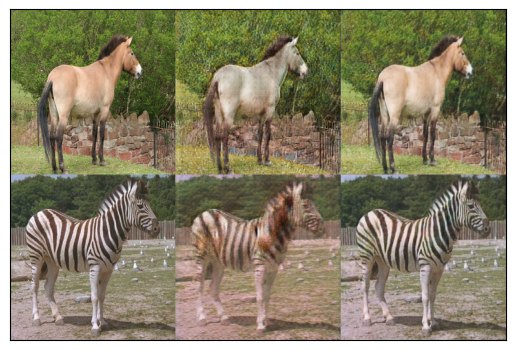

loss - A2Bg: 0.79008996 - B2Ag: 0.8019686 - A2B2Ac: 0.048072882 - B2A2Bc: 0.096922345
loss - Ad: 0.13829689 - Bd: 0.03593099 - DAgp: 0.0 - BBgp: 0.0



Inner Epoch Loop:   3%|█▊                                                            | 40/1334 [00:58<31:22,  1.46s/it]

poch Loop:  12%|███████▉                                                             | 23/200 [00:58<07:28,  2.53s/it]

KeyboardInterrupt: 

In [11]:
# ==============================================================================
# =                                    run                                     =
# ==============================================================================

'''
print('G_A2B:')
print(G_A2B.summary())
print('G_B2A:')
print(G_B2A.summary())
print('D_A:')
print(D_A.summary())
print('D_B:')
print(D_B.summary())
'''
# epoch counter
ep_cnt = tf.Variable(initial_value=0, trainable=False, dtype=tf.int64)

# checkpoint
checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_A=D_A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                ep_cnt=ep_cnt),
                           py.join(output_dir, 'checkpoints'),
                           max_to_keep=5)
try:  # restore checkpoint including the epoch counter
    checkpoint.restore().assert_existing_objects_matched()
    print('checkpoint loaded...')
except Exception as e:
    print(e)

# summary
train_summary_writer = tf.summary.create_file_writer(py.join(output_dir, 'summaries', 'train'))

# sample
test_iter = iter(A_B_dataset_test)
sample_dir = py.join(output_dir, 'samples_training')
py.mkdir(sample_dir)


# main loop
with train_summary_writer.as_default():
    for ep in tqdm.trange(args.epochs, desc='Epoch Loop'):
        if ep < ep_cnt:
            continue

        # update epoch counter
        ep_cnt.assign_add(1)

        # train for an epoch
        for A, B in tqdm.tqdm(A_B_dataset, desc='Inner Epoch Loop', total=len_dataset):
            G_loss_dict, D_loss_dict = train_step(A, B)

            # # summary
            tl.summary(G_loss_dict, step=G_optimizer.iterations, name='G_losses')
            tl.summary(D_loss_dict, step=G_optimizer.iterations, name='D_losses')
            tl.summary({'learning rate': G_lr_scheduler.current_learning_rate}, step=G_optimizer.iterations, name='learning rate')

            # sample
            # if G_optimizer.iterations.numpy() % 100 == 0:
            if G_optimizer.iterations.numpy() % 10 == 0:
                clear_output()
                A, B = next(test_iter)
                A2B, B2A, A2B2A, B2A2B = sample(A, B)
                img = im.immerge(np.concatenate([A, A2B, A2B2A, B, B2A, B2A2B], axis=0), n_rows=2)
                show(img)
                print(
                    'loss - A2Bg: ' + str(G_loss_dict['A2B_g_loss'].numpy()) +
                    ' - B2Ag: ' + str(G_loss_dict['B2A_g_loss'].numpy()) +
                    ' - A2B2Ac: ' + str(G_loss_dict['A2B2A_cycle_loss'].numpy()) +
                    ' - B2A2Bc: ' + str(G_loss_dict['B2A2B_cycle_loss'].numpy())
                )
                print(
                    'loss - Ad: ' + str(D_loss_dict['A_d_loss'].numpy()) +
                    ' - Bd: ' + str(D_loss_dict['B_d_loss'].numpy()) +
                    ' - DAgp: ' + str(D_loss_dict['D_A_gp'].numpy()) +
                    ' - BBgp: ' + str(D_loss_dict['D_B_gp'].numpy())
                )

                # save checkpoint
                checkpoint.save(ep)
